## Modeling exercises 

In [3]:


import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# wrangle
import acquire
import prepare

# working with dates
from datetime import datetime

# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

# for tsa 
import statsmodels.api as sm

# holt's linear trend model. 
from statsmodels.tsa.api import Holt, ExponentialSmoothing

In [4]:
# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

Using [saas.csv](https://ds.codeup.com/saas.csv) or log data from API usage or store_item_sales

In [5]:
url = 'https://ds.codeup.com/saas.csv'
df = pd.read_csv(url)
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [6]:
df.columns = df.columns.str.lower()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   month_invoiced     790458 non-null  object 
 1   customer_id        790458 non-null  int64  
 2   invoice_id         790458 non-null  int64  
 3   subscription_type  790458 non-null  float64
 4   amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


In [8]:
df.month_invoiced = pd.to_datetime(df.month_invoiced)

In [9]:
df = df.set_index('month_invoiced').sort_index()

In [10]:
del df['customer_id']

In [11]:
del df['invoice_id']

In [12]:
df.head(1)

,subscription_type,amount
month_invoiced,,
2014-01-31,0.0,0.0


In [13]:
df.subscription_type.value_counts()

0.0    496410
1.0    178212
2.0     70706
3.0     26474
4.0     18656
Name: subscription_type, dtype: int64

In [14]:
df.amount.value_counts()

0.0     496410
5.0     178212
10.0     70706
15.0     26474
20.0     18656
Name: amount, dtype: int64

In [16]:
df.subscription_type = df.subscription_type.astype('uint8')

In [17]:
df.amount = df.amount.astype('uint8')

In [44]:
(df.amount != df.subscription_type * 5).sum()

0

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 790458 entries, 2014-01-31 to 2017-12-31
Data columns (total 2 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   subscription_type  790458 non-null  uint8
 1   amount             790458 non-null  uint8
dtypes: uint8(2)
memory usage: 7.5 MB


In [19]:
pd.crosstab(df.subscription_type, df.amount)

amount,0,5,10,15,20
subscription_type,,,,,
0,496410,0,0,0,0
1,0,178212,0,0,0
2,0,0,70706,0,0
3,0,0,0,26474,0
4,0,0,0,0,18656


In [20]:
pd.concat([df.head(1), df.tail(1)])

,subscription_type,amount
month_invoiced,,
2014-01-31,0,0
2017-12-31,0,0


In [ ]:
drop 

**1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum.**

In [21]:
train_size = int(round(df.shape[0] * 0.5))
validate_size = int(round(df.shape[0] * 0.3))
test_size = int(round(df.shape[0] * 0.2))

In [22]:
# confirm the length
len(df) == train_size + validate_size + test_size

True

In [25]:
validate_end_index = train_size + validate_size
train = df[:train_size].copy()
validate = df[train_size:validate_end_index].copy()
test = df[validate_end_index:].copy()

In [26]:
pd.concat([train.tail(3), validate.head(3)])

,subscription_type,amount
month_invoiced,,
2015-10-31,1,5
2015-10-31,0,0
2015-10-31,0,0
2015-10-31,0,0
2015-10-31,0,0
2015-10-31,1,5


In [28]:
# breaks the same date into train and validate. I'll train a different approach for the split
del train 
del validate
del test

In [30]:
del train_size
del validate_size
del test_size
del validate_end_index

In [33]:
len(df.index) == df.index.nunique()

False

In [35]:
df.index.nunique()

48

In [37]:
list(df.index.unique())

[Timestamp('2014-01-31 00:00:00'),
 Timestamp('2014-02-28 00:00:00'),
 Timestamp('2014-03-31 00:00:00'),
 Timestamp('2014-04-30 00:00:00'),
 Timestamp('2014-05-31 00:00:00'),
 Timestamp('2014-06-30 00:00:00'),
 Timestamp('2014-07-31 00:00:00'),
 Timestamp('2014-08-31 00:00:00'),
 Timestamp('2014-09-30 00:00:00'),
 Timestamp('2014-10-31 00:00:00'),
 Timestamp('2014-11-30 00:00:00'),
 Timestamp('2014-12-31 00:00:00'),
 Timestamp('2015-01-31 00:00:00'),
 Timestamp('2015-02-28 00:00:00'),
 Timestamp('2015-03-31 00:00:00'),
 Timestamp('2015-04-30 00:00:00'),
 Timestamp('2015-05-31 00:00:00'),
 Timestamp('2015-06-30 00:00:00'),
 Timestamp('2015-07-31 00:00:00'),
 Timestamp('2015-08-31 00:00:00'),
 Timestamp('2015-09-30 00:00:00'),
 Timestamp('2015-10-31 00:00:00'),
 Timestamp('2015-11-30 00:00:00'),
 Timestamp('2015-12-31 00:00:00'),
 Timestamp('2016-01-31 00:00:00'),
 Timestamp('2016-02-29 00:00:00'),
 Timestamp('2016-03-31 00:00:00'),
 Timestamp('2016-04-30 00:00:00'),
 Timestamp('2016-05-

In [46]:
del df['subscription_type']

In [47]:
train = df.loc[:'2015'].copy()
validate = df.loc['2016'].copy()
test = df.loc['2017'].copy()

In [48]:
pd.concat([train.tail(3), validate.head(3)])

,amount
month_invoiced,
2015-12-31,0
2015-12-31,0
2015-12-31,0
2016-01-31,5
2016-01-31,0
2016-01-31,5


In [49]:
pd.concat([validate.tail(3), test.head(3)])

,amount
month_invoiced,
2016-12-31,0
2016-12-31,0
2016-12-31,0
2017-01-31,5
2017-01-31,0
2017-01-31,5


In [54]:
train = train.resample('M').sum()
validate = validate.resample('M').sum()
test = test.resample('M').sum()

In [55]:
train.head()

,amount
month_invoiced,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0
2014-04-30,39255.0
2014-05-31,40355.0


In [56]:
len(train), len(validate), len(test)

(24, 12, 12)

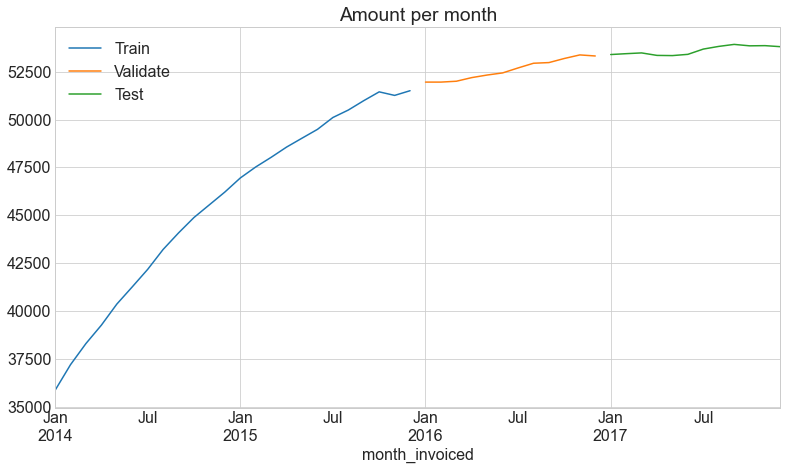

In [63]:
for col in train.columns:
    train[col].plot(label='Train')
    validate[col].plot(label='Validate')
    test[col].plot(label='Test')
    plt.title('Amount per month')
    plt.legend()
    plt.show()

**2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:**
  - Simple Average
  - Moving Average
  - Holt's Linear Trend Model
  - Based on previous year/month/etc., this is up to you.

In [ ]:
pd.DataFrame(
    {'sales_total': [last_sales],
     'sale_amount': [last_quantity]},
    index=validate.index)

In [64]:
predictions_train = pd.DataFrame(index=train.index)
predictions_validate = pd.DataFrame(index=validate.index)

In [67]:
predictions_train.head(1)

""
month_invoiced
2014-01-31


In [68]:
scores = pd.DataFrame(columns=['model_name', 'train_score', 'validate_score'])

In [86]:
def evaluate(target_name: str, model_name: str):
    RMSE_train = round(np.sqrt(mean_squared_error(train[target_name], predictions_train[model_name])))
    RMSE_validate = round(np.sqrt(mean_squared_error(validate[target_name], predictions_validate[model_name])))
    scores.loc[len(scores)] = [model_name, RMSE_train, RMSE_validate]
    
    # plot
    plt.figure(figsize = (12,4))
    plt.plot(train[target_name], label='Train', linewidth=1)
    plt.plot(validate[target_name], label='Validate', linewidth=1)
    plt.plot(predictions_train[model_name], label=model_name + '_train')
    plt.plot(predictions_validate[model_name], label=model_name + '_validate')
    plt.title(target_name)
    
    print(target_name, '-- RMSE train: {:.0f}'.format(RMSE_train))
    print(target_name, '-- RMSE validate: {:.0f}'.format(RMSE_validate))
    plt.show()

#### Simple Average

In [73]:
avg_amount = round(train['amount'].mean(), 2)

In [74]:
avg_amount

45568.54

In [75]:
predictions_train['simple_average'] = avg_amount
predictions_validate['simple_average'] = avg_amount

In [77]:
predictions_validate.head()

,simple_average
month_invoiced,
2016-01-31,45568.54
2016-02-29,45568.54
2016-03-31,45568.54
2016-04-30,45568.54
2016-05-31,45568.54


amount -- RMSE train: 4777
amount -- RMSE validate: 7063


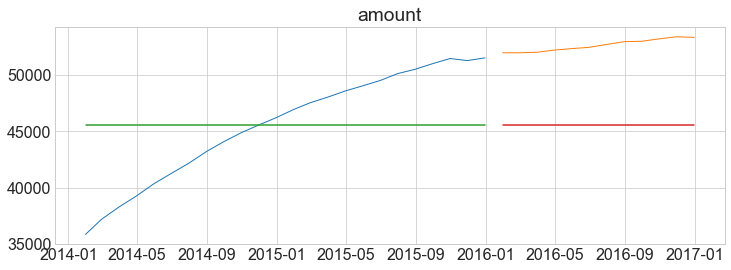

In [89]:
evaluate('amount', 'simple_average')

In [90]:
scores

,model_name,train_score,validate_score
0,simple_average,4777,7063


In [87]:
# to remove values from scores
scores.drop(scores.index, axis=0, inplace=True)

#### Moving Average

In [99]:
target = 'amount'

In [97]:
period = 3
ma = 'moving_average'
rolling_amount = round(train.amount.rolling(period).mean()[-1], 2)
predictions_train[ma] = rolling_amount
predictions_validate[ma] = rolling_amount

amount -- RMSE train: 7541
amount -- RMSE validate: 1315


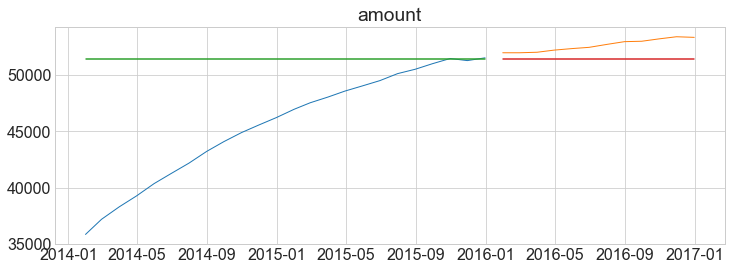

In [100]:
evaluate(target, ma)

In [101]:
scores

,model_name,train_score,validate_score
0,simple_average,4777,7063
1,moving_average,7541,1315


#### Holt's Linear Trend Model

In [104]:
holt_linear = 'holt_linear'

In [109]:
# create the Holt object 
holt = Holt(train[target], exponential=False, damped_trend=True)
# fit the model 
holt = holt.fit(optimized=True)
# make predictions for the train set

In [114]:
predictions_train[holt_linear] = round(holt.predict(start = train.index[0],
                                   end = train.index[-1]),2)
# make predictions for the validate set
predictions_validate[holt_linear] = round(holt.predict(start = validate.index[0],
                                   end = validate.index[-1]),2)

In [116]:
predictions_validate.head(1)

,simple_average,moving_average,holt_linear
month_invoiced,,,
2016-01-31,45568.54,51403.33,51748.62


amount -- RMSE train: 213
amount -- RMSE validate: 346


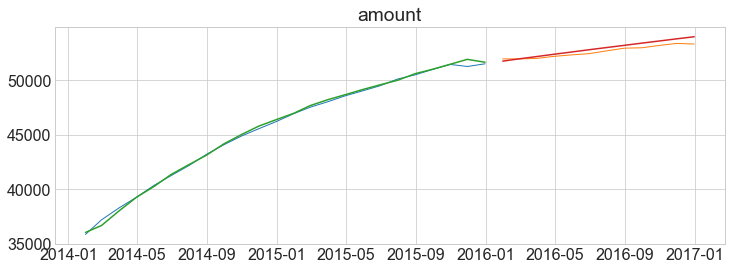

In [117]:
evaluate(target, holt_linear)

In [119]:
scores.sort_values(by=['train_score', 'validate_score'])

,model_name,train_score,validate_score
2,holt_linear,213,346
0,simple_average,4777,7063
1,moving_average,7541,1315


I will run the use **Holt Linear Trend model** on the *test data set* as it is making best predictions both on train and validate sets

In [120]:
predictions_test = holt.predict(start = test.index[0],
                                   end = test.index[-1])

#### Plot final results

In [131]:
def plot_final_result(target_name=target, model_name=holt_linear):
    predictions_test = holt.predict(start = test.index[0],
                                   end = test.index[-1])
    plt.figure(figsize = (12,4))
    plt.plot(train[target_name], label='Train', linewidth=10, alpha=.2)
    plt.plot(validate[target_name], label='Validate', linewidth=10, alpha=.2)
    plt.plot(test[target_name], label='Test', linewidth=10, alpha=.2)
    plt.plot(predictions_train[model_name], label=model_name + '_train')
    plt.plot(predictions_validate[model_name], label=model_name + '_validate')
    plt.plot(predictions_test, label=model_name + '_test')
    plt.legend()
    plt.title(target_name)
    
    print(f'RMSE test {np.sqrt(mean_squared_error(test[target_name], predictions_test))}')

RMSE test 1645.3810973059449


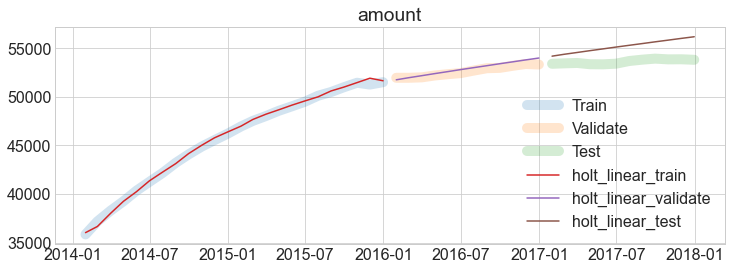

In [132]:
plot_final_result()

Optional: Using store item demand

1. Predict 2018 total **monthly** sales for a single store and/or item by creating a model using prophet.

2. Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper).

3. Plot the 2018 monthly sales predictions.